# Import Data

In [43]:
#Import packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot  as plt
import shapely.geometry as shp
from shapely.ops import linemerge
import numpy as np
import itertools
import pickle
import matplotlib as mpl
import matplotlib.lines as mlines

# Define notebook path with pathlib
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve() 
DATA_PATH = NOTEBOOK_PATH/'data'

# Import France Map
France = pd.read_pickle(DATA_PATH/'France_metropolitaine.pkl')

# Import capture and storage sites
capture_sites           = pd.read_pickle(DATA_PATH/'data_clean'/'capture_sites.pkl')
storage_sites           = pd.read_pickle(DATA_PATH/'data_clean'/'storage_sites.pkl')
edges_gdf               = pd.read_pickle(DATA_PATH/'data_clean'/'edges_gdf.pkl')
incidence               = pd.read_pickle(DATA_PATH/'data_clean'/'incidence.pkl')
nodes                   = pd.read_pickle(DATA_PATH/'data_clean'/'nodes.pkl')

# Import scenario
with open(NOTEBOOK_PATH/'results'/'MILP_results.pkl','rb') as file:
    res = pickle.load(file)

# Multiple legends for figures
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


# Results

## Qpos, Qneg and delta

In [44]:
def Var_pipe(variable):
    name = str(variable)
    var = res[ "v_" + name ]
    var.rename(columns=
                {'index':'pipeline'
                ,0: name}
                , inplace= True
    )
    var = var.drop(var.loc[ var[name] ==0 ].index)
    return var

qpos = Var_pipe("qpositive")
qneg = Var_pipe("qnegative")
delta = Var_pipe("delta")


# Verification
len(delta) == len(qpos) + len(qneg)


True

## Total costs

In [45]:
# Total cost
capex = res["v_TotalPipeCapex"]
opex  = res["v_TotalPipeOpex"]

## Qtrans

In [46]:
# Merge qpos and qneg quantities with geodata
qpos = qpos.merge(edges_gdf.reset_index(names="pipeline"),
           how="inner",
           on="pipeline",
           validate = "1:1"   
)
qneg = qneg.merge(edges_gdf.reset_index(names="pipeline"),
           how="inner",
           on="pipeline",
           validate = "1:1"   
)

# Convert both dfs into geo dfs
qpos = gpd.GeoDataFrame(
        qpos,
        crs="EPSG:4326",
        geometry = "geometry"
)
qneg = gpd.GeoDataFrame(
        qneg,
        crs="EPSG:4326",
        geometry = "geometry"
)


In [47]:
# Concat the gdfs into a single gdf
qtrans_pos = qpos.rename(columns={"qpositive":"qtrans"})
qtrans_neg = qneg.rename(columns={"qnegative":"qtrans"})

qtrans_pos["type"] = qtrans_pos["qtrans"] / qtrans_pos["qtrans"] 
qtrans_neg["type"] = - qtrans_neg["qtrans"] / qtrans_neg["qtrans"]


qtrans = gpd.GeoDataFrame(
    pd.concat([qtrans_pos,qtrans_neg],axis=0,join='outer',ignore_index=True),
    crs = qpos.crs
)

In [48]:
d = 0.07
sum = 0

Cfix_morbee = 0.533             # in [M€/km]
Cvol_morbee = 0.019             # in [M€ / (km * (MtCO2/y)]

for i in range(0,30):
    sum = sum + 1/(1+d)**i
sum

Cfix = Cfix_morbee / sum        # Annualized invetment fix cost [M€/km/y]
Cvol = Cvol_morbee / sum        # Annualized investment variable cost   [M€/km/(MtCO2/y) / y]
Copex = 0.01                    # O&m cost [M€/MtCO2/km]

print(Cfix) 
print(Cvol)

0.040142572963946056
0.00143097352029076


In [49]:
# Reminder: qtrans is in [MtCO2/y]

# Change crs to projected crs to calculate distances
pipe_cost = qtrans.to_crs("EPSG:2154")
pipe_cost["length(km)"] = pipe_cost["geometry"].length / 1e3 # distance in [km]
pipe_cost["pipe_capex"] = (Cfix + Cvol * pipe_cost["qtrans"] ) *pipe_cost["length(km)"] # CAPEX in [M€/y]
pipe_cost["pipe_opex"] = Copex * pipe_cost["qtrans"] * pipe_cost["length(km)"] # OPEX in [M€/y]
pipe_cost["pipe_tc"] = pipe_cost["pipe_capex"] + pipe_cost["pipe_opex"]

# Verification
# summing over all pipelines we find capex and opex of total cost so OK

# Switch back to geographical CRS
pipe_cost = pipe_cost.to_crs("EPSG:4326")

# Verify if there are duplicated pipelines
# if there are, it is a mistake
# pipe_cost[pipe_cost["pipeline"].duplicated(keep=False)]

In [50]:
start_pts = incidence.loc[incidence["inc"]==-1]
end_pts   = incidence.loc[incidence["inc"]==1]

In [51]:

pipe_cost = pipe_cost.merge(
    start_pts[["pipelines","nodes","nodes_geom"]],
    left_on="pipeline",
    right_on="pipelines",
    how="inner",
    validate= "1:1"
)
pipe_cost.drop(columns="pipelines",inplace=True)
pipe_cost.rename(columns=
        {"nodes":"start_pt",
         "nodes_geom":"start_pt_geom"},
         inplace=True
)

pipe_cost = pipe_cost.merge(
    end_pts[["pipelines","nodes","nodes_geom"]],
    left_on="pipeline",
    right_on="pipelines",
    how="inner",
    validate= "1:1"
)
pipe_cost.drop(columns="pipelines",inplace=True)
pipe_cost.rename(columns=
        {"nodes":"end_pt",
         "nodes_geom":"end_pt_geom"},
         inplace=True
)


In [52]:
# Set starting points as effective starting points of pipelines
# We change the value when the flow is qneg
qneg_index = (pipe_cost["type"]<0)
pipe_cost.loc[qneg_index,["start_pt","end_pt"]] = pipe_cost.loc[qneg_index,["end_pt","start_pt"]].values

In [53]:
# Add capture cost
pipe_cost = pipe_cost.merge(
    capture_sites[["captured_emi(MtCO2/y)","cost(tCO2_avoided)"]],
    left_on="start_pt",
    right_index=True,
    how="inner",
    # validate="1:1"
)
pipe_cost["capture_tc"]  = pipe_cost["captured_emi(MtCO2/y)"] * pipe_cost["cost(tCO2_avoided)"] 

# capture_tc is in [M€/y]
# [MtCO2/y] * [€/tCO2avoided]

# Re order columns
cols = ["pipeline","start_pt","end_pt","qtrans","capture_tc",
        "pipe_tc","pipe_capex","pipe_opex","start_pt_geom","end_pt_geom",
        "geometry","length(km)","cost(tCO2_avoided)","captured_emi(MtCO2/y)","type"]
pipe_cost = pipe_cost[cols]

# Clusters

In [54]:
# Step 1: Create a dictionary to map each point to its connected storage point
connected_storage = {}

def dfs(point, storage_point, visited):
    visited.add(point)
    connected_storage[point] = storage_point

    for _, row in pipe_cost.iterrows():
        if row['start_pt'] == point and row['end_pt'] not in visited:
            dfs(row['end_pt'], storage_point, visited)
        elif row['end_pt'] == point and row['start_pt'] not in visited:
            dfs(row['start_pt'], storage_point, visited)

# Step 2: Traverse the graph using DFS and assign clusters based on connected storage points
visited_points = set()

for _, row in pipe_cost.iterrows():
    if row['end_pt'].startswith('S') and row['end_pt'] not in visited_points:
        dfs(row['end_pt'], row['end_pt'], visited_points)

# Step 3: Create a dictionary to map each pipeline to its cluster
pipeline_to_cluster = {pipeline: connected_storage[end_pt] for pipeline, end_pt in zip(pipe_cost['pipeline'], pipe_cost['end_pt'])}

# Step 4: Assign clusters to GeoDataFrame
pipe_cost['cluster'] = pipe_cost['pipeline'].apply(lambda x: pipeline_to_cluster.get(x))



In [55]:
capture_sites = capture_sites.reset_index(names="capture_name").set_index("capture_name")
capture_sites = capture_sites.drop(columns="index")

capture_sites = capture_sites.merge(
    pipe_cost[["start_pt","cluster"]],
    how="inner",
    left_on="capture_name",
    right_on="start_pt",
    validate="1:1"
)

## Clusters- S0

In [56]:
# We want to plot capture sites that are in specific French regions and in the S0 cluster
# We select capture sites in regions under concern
capture_S0_regions = capture_sites.loc[(capture_sites["geometry"].within(France.loc["Bourgogne-Franche-Comté","geometry"]))
                  | (capture_sites["geometry"].within(France.loc["Auvergne-Rhône-Alpes","geometry"]))]

# Among these sites, we only keep those that are in S0 cluster
# (in this case they are all in S0)
capture_S0_regions = capture_S0_regions.loc[capture_S0_regions["cluster"]=="S0"]


# We repeat with pipelines that are in the regions and S0 cluster
pipelines_S0_regions = pipe_cost.loc[pipe_cost.within(France.loc["Bourgogne-Franche-Comté","geometry"].
                                          union(France.loc["Auvergne-Rhône-Alpes","geometry"]))]

# Among these pipelines, we only keep those that are in S0 cluster
# (in this case they are all in S0)
pipelines_S0_regions = pipelines_S0_regions.loc[pipelines_S0_regions["cluster"]=="S0"]

In [57]:
pipelines_S0_regions

,pipeline,start_pt,end_pt,qtrans,capture_tc,pipe_tc,pipe_capex,pipe_opex,start_pt_geom,end_pt_geom,geometry,length(km),cost(tCO2_avoided),captured_emi(MtCO2/y),type,cluster
11,P50,C25,C33,0.677433,18.435105,1.216063,1.044030,0.172033,POINT (4.65972 45.86569),POINT (4.84318 45.67646),"LINESTRING (4.65972 45.86569, 4.84318 45.67645)",25.394802,50,0.368702,1.0,S0
13,P57,C8,C22,2.339219,60.557483,7.643134,4.969929,2.673205,POINT (4.84185 45.67007),POINT (4.75498 44.64295),"LINESTRING (4.84185 45.67007, 4.75498 44.64295)",114.277681,100,0.605575,1.0,S0
17,P72,C22,C34,2.715838,18.830925,1.036144,0.640848,0.395295,POINT (4.75498 44.64295),POINT (4.68893 44.52072),"LINESTRING (4.75498 44.64295, 4.68893 44.52072)",14.555186,50,0.376619,1.0,S0
19,P89,C26,C33,0.841119,18.178965,2.346126,1.949527,0.396599,POINT (5.42112 45.80497),POINT (4.84318 45.67646),"LINESTRING (5.42112 45.80497, 4.84318 45.67645)",47.151306,50,0.363579,1.0,S0
29,P28,C29,C25,0.308731,15.436530,4.568114,4.245178,0.322936,POINT (4.65972 45.86569),POINT (3.42496 46.2508),"LINESTRING (4.65972 45.86569, 3.42496 46.2508)",104.601323,50,0.308731,-1.0,S0
35,P68,C33,C8,1.733644,21.509236,0.042966,0.030543,0.012423,POINT (4.84185 45.67007),POINT (4.84318 45.67646),"LINESTRING (4.84185 45.67007, 4.84318 45.67645)",0.716573,100,0.215092,-1.0,S0
39,P96,C35,C26,0.262587,13.129335,6.388809,5.999969,0.388839,POINT (5.42112 45.80497),POINT (5.55251 47.13524),"LINESTRING (5.42112 45.80497, 5.55251 47.13524)",148.080383,50,0.262587,-1.0,S0
40,P108,C37,C26,0.214953,10.747665,2.839060,2.695804,0.143256,POINT (5.42112 45.80497),POINT (5.66879 45.23067),"LINESTRING (5.42112 45.80497, 5.66879 45.23067)",66.645072,50,0.214953,-1.0,S0


# Figure 4

## Figure 4 - Main map

In [58]:
# Create custom legend for plots
def custom_legend_handler(capture_sites, cmap):
    handles = []
    unique_categories = capture_sites['original_inventory_sector'].unique()
    norm = Normalize(vmin=0, vmax=len(unique_categories) - 1)
    scalar_map = ScalarMappable(norm=norm, cmap=cmap)
    for idx, category in enumerate(sorted(unique_categories)):  # Sort categories based on colormap order
        handle = plt.scatter([], [], label=category, color=scalar_map.to_rgba(idx))
        handles.append(handle)  
    return handles

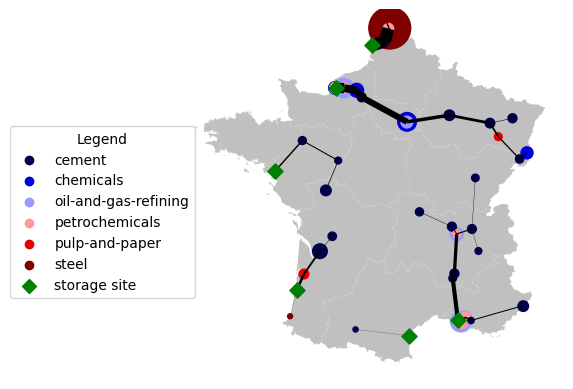

In [59]:
# Map emitters all
fig, axes = plt.subplots()
plt.axis('off')

## France
France.plot(color='silver', ax=axes)

# Capture sites
capture_sites.plot(
    ax=axes,
    column="original_inventory_sector",
    cmap="seismic",
    markersize=capture_sites['emissions_quantity'] / 1e4,
    legend=False,
)

# Create custom legend for capture sites
capture_legend_handles = custom_legend_handler(capture_sites, "seismic")


# Plot Pipelines
qtrans.plot(
    ax=axes,
    color='black',
    linewidth=qtrans["qtrans"],
    zorder=1
)

# Storage sites
storage_sites.plot(
    ax=axes,
    color='green',
    marker="D",
    markersize=60,
    zorder=2
)


# Legend handles
# pipeline_handle = mlines.Line2D([], [], color='black', label='Pipeline route')
storage_handle = plt.scatter([], [], color='green', label='storage site', marker='D', s=50)
# legend_handles = capture_legend_handles + [storage_handle, pipeline_handle]
legend_handles = capture_legend_handles + [storage_handle]

# Legend Box
plt.legend(
    handles=legend_handles,
    loc='lower left',
    bbox_to_anchor=(-0.45, 0.2),
    title="Legend"
)

# plt.show()
# plt.savefig('Map_emitters.png',bbox_inches = "tight")
plt.savefig(NOTEBOOK_PATH/'results'/'figures'/'Figure_4_main.png', bbox_inches = "tight")


## Figure 4 - Cluster

In [60]:
n_lines = 6 # there are six orignal inventory sectors
cmap = mpl.colormaps['seismic']

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))

# Define all unique sectors in the right order
unique_sectors = ['cement', 'chemicals', 'oil-and-gas-refining', 'petrochemicals', 'pulp-and-paper', 'steel']

# Create a dictionary associating sectors with colors
sector_color_dict = dict(zip(unique_sectors, colors))


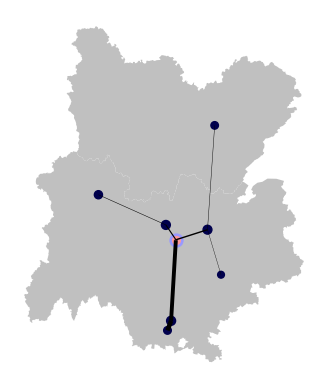

In [61]:

fig, axes = plt.subplots()
plt.axis('off')

# France
France.loc[["Bourgogne-Franche-Comté","Auvergne-Rhône-Alpes"],"geometry"].plot(color='silver', ax=axes)

# Plot capture sites with correct colors for each sector
legend_handles = []  # Initialize list to store legend handles
for sector, color in sector_color_dict.items():
    if sector in capture_S0_regions['original_inventory_sector'].unique():
        sector_data = capture_S0_regions[capture_S0_regions['original_inventory_sector'] == sector]
        # Plot sector data with markers of fixed size for legend
        handle = plt.scatter([], [], color=color, label=sector, s=100)  # Adjust the size (100) as needed
        legend_handles.append(handle)  # Add handle to the list
        # Plot sector data on the main plot with variable marker size
        sector_data.plot(
            ax=axes,
            color=color,
            markersize= sector_data['emissions_quantity'] / 1e4,
        )

# S0 cluster
pipeline_handle = mlines.Line2D([], [], color='black', label='pipeline')
legend_handles.append(pipeline_handle)  # Add pipeline handle to the list
pipelines_S0_regions.plot(
    ax=axes,
    color='black',
    linewidth=pipelines_S0_regions["qtrans"] * 1.2
)

plt.savefig(NOTEBOOK_PATH/'results'/'figures'/'Figure_4_cluster.png', bbox_inches="tight")




# Bankruptcy results

## Import MILP results

In [62]:
milp_res_df = pipelines_S0_regions[["start_pt","capture_tc","pipe_tc"]]

# Use variables of the paper
milp_res_df.set_index("start_pt",inplace=True)
milp_res_df = milp_res_df.rename(columns={
        "capture_tc":"xi",
        "pipe_tc":"yipi"
    })

# Add Shapley value column (calculated by hand separately)
sha_values = {
    'C22': 0.13,
    'C8': 1.22,
    'C33': 1.23,
    'C25': 1.83,
    'C29': 6.39,
    'C26': 2.01,
    'C37': 4.85,
    'C35': 8.41
}
milp_res_df["Shi"] = milp_res_df.index.map(sha_values)

# Add ci column
milp_res_df["ci"] = milp_res_df["xi"] + milp_res_df["Shi"]

# Round values 
milp_res_df = milp_res_df.round(2)

# Define budget (fixed value in paper)
budget = 170



In [63]:
# For readability with paper, we re-order the rows
re_order = ['C22', 'C8', 'C33', 'C25', 'C29', 'C26', 'C37', 'C35']
milp_res_df = milp_res_df.reindex(re_order)
milp_res_df.round(2)


,xi,yipi,Shi,ci
start_pt,,,,
C22,18.83,1.04,0.13,18.96
C8,60.56,7.64,1.22,61.78
C33,21.51,0.04,1.23,22.74
C25,18.44,1.22,1.83,20.27
C29,15.44,4.57,6.39,21.83
C26,18.18,2.35,2.01,20.19
C37,10.75,2.84,4.85,15.60
C35,13.13,6.39,8.41,21.54


## P solution

In [64]:
# Proportional solution

# Calculate proportional allocation with the network
milp_res_df["P_c"] = (milp_res_df["ci"] / milp_res_df["ci"].sum() * budget).round(2)

# Calculate proportional allocation without the network
milp_res_df["P_x"] = (milp_res_df["xi"] / milp_res_df["xi"].sum() * budget).round(2)

## CEA

In [65]:
# CEA solution (with network)

# Create a working copy to track remaining claimants
milp_res_df['CEA_c'] = 0.0  # Initialize CEA column
working_df = milp_res_df.copy()
working_df['remaining_claim'] = working_df['ci']

budget_copy = budget

while budget_copy > 0 and not working_df.empty:
    n = len(working_df)
    if n == 0:
        break
    share = budget_copy / n

    # We find who can take the full share without exceeding their claim
    fulfilled = working_df['remaining_claim'] <= share 
    not_fulfilled = ~fulfilled

    # Allocate to fully fulfilled
    milp_res_df.loc[working_df[fulfilled].index, 'CEA_c'] += working_df[fulfilled]['remaining_claim']
    budget_copy -= working_df[fulfilled]['remaining_claim'].sum()

    # Allocate share to others
    milp_res_df.loc[working_df[not_fulfilled].index, 'CEA_c'] += share
    budget_copy -= share * not_fulfilled.sum()

    # Update remaining claims
    working_df.loc[not_fulfilled, 'remaining_claim'] -= share
    working_df = working_df[not_fulfilled]  

In [66]:
# CEA solution (without network)

budget_copy = budget
# Create a working copy to track remaining claimants
milp_res_df['CEA_x'] = 0.0  # Initialize CEA_x column
working_df = milp_res_df.copy()
working_df['remaining_claim'] = working_df['xi']

while budget_copy > 0 and not working_df.empty:
    n = len(working_df)
    if n == 0:
        break
    share = budget_copy / n

    # Find who can take the full share without exceeding their claim
    fulfilled = working_df['remaining_claim'] <= share #returns a boolean series
    not_fulfilled = ~fulfilled

    # Allocate to fully fulfilled
    milp_res_df.loc[working_df[fulfilled].index, 'CEA_x'] += working_df[fulfilled]['remaining_claim']
    budget_copy -= working_df[fulfilled]['remaining_claim'].sum()

    # Allocate share to others
    milp_res_df.loc[working_df[not_fulfilled].index, 'CEA_x'] += share
    budget_copy -= share * not_fulfilled.sum()

    # Update remaining claims
    working_df.loc[not_fulfilled, 'remaining_claim'] -= share
    working_df = working_df[not_fulfilled]  # Remove fulfilled


## CEL

In [67]:
# CEL solution (with network)
milp_res_df['CEL_c'] = milp_res_df['ci']  # Start with full claims
working_df = milp_res_df.copy()
working_df['remaining_award'] = working_df['ci'] 
total_claims = working_df['ci'].sum()
losses_to_distribute = total_claims - budget

while losses_to_distribute > 0 and not working_df.empty:
    n = len(working_df)
    if n == 0:
        break
    loss_share = losses_to_distribute / n

    # Who will be reduced to zero (can't lose full share)?
    exhausted = working_df['remaining_award'] <= loss_share
    not_exhausted = ~exhausted

    # Fully remove exhausted ones (set award to 0)
    milp_res_df.loc[working_df[exhausted].index, 'CEL_c'] -= working_df[exhausted]['remaining_award']
    losses_to_distribute -= working_df[exhausted]['remaining_award'].sum()

    # Remove partial loss from others
    milp_res_df.loc[working_df[not_exhausted].index, 'CEL_c'] -= loss_share
    losses_to_distribute -= loss_share * not_exhausted.sum()

    # Update working_df for next iteration
    working_df.loc[not_exhausted, 'remaining_award'] -= loss_share
    working_df = working_df[not_exhausted] 


In [68]:
# CEL solution (without network)
milp_res_df['CEL_x'] = milp_res_df['xi']  # Start with full claims
working_df = milp_res_df.copy()
working_df['remaining_award'] = working_df['xi'] 
total_claims = working_df['xi'].sum()
losses_to_distribute = total_claims - budget

while losses_to_distribute > 0 and not working_df.empty:
    n = len(working_df)
    if n == 0:
        break
    loss_share = losses_to_distribute / n

    # Who will be reduced to zero (can't lose full share)?
    exhausted = working_df['remaining_award'] <= loss_share
    not_exhausted = ~exhausted

    # Fully remove exhausted ones (set award to 0)
    milp_res_df.loc[working_df[exhausted].index, 'CEL_c'] -= working_df[exhausted]['remaining_award']
    losses_to_distribute -= working_df[exhausted]['remaining_award'].sum()

    # Remove partial loss from others
    milp_res_df.loc[working_df[not_exhausted].index, 'CEL_x'] -= loss_share
    losses_to_distribute -= loss_share * not_exhausted.sum()

    # Update working_df for next iteration
    working_df.loc[not_exhausted, 'remaining_award'] -= loss_share
    working_df = working_df[not_exhausted]  # Drop those fully exhausted

## Bankruptcy results in a single table

All results are computed in res_df which is the basis for the various tables shown in the paper

In [69]:
milp_res_df["CEA/ci"] = milp_res_df["CEA_c"] / milp_res_df["ci"]
milp_res_df["CEL/ci"] = milp_res_df["CEL_c"] / milp_res_df["ci"]
milp_res_df["P/ci"] = milp_res_df["P_c"] / milp_res_df["ci"]

In [70]:
milp_res_df

,xi,yipi,Shi,ci,P_c,P_x,CEA_c,CEA_x,CEL_c,CEL_x,CEA/ci,CEL/ci,P/ci
start_pt,,,,,,,,,,,,,
C22,18.83,1.04,0.13,18.96,15.88,18.10,18.96,18.83,14.84625,17.975,1.000000,0.783030,0.837553
C8,60.56,7.64,1.22,61.78,51.76,58.22,28.87,53.72,57.66625,59.705,0.467303,0.933413,0.837812
C33,21.51,0.04,1.23,22.74,19.05,20.68,22.74,21.51,18.62625,20.655,1.000000,0.819096,0.837731
C25,18.44,1.22,1.83,20.27,16.98,17.73,20.27,18.44,16.15625,17.585,1.000000,0.797052,0.837691
C29,15.44,4.57,6.39,21.83,18.29,14.84,21.83,15.44,17.71625,14.585,1.000000,0.811555,0.837838
C26,18.18,2.35,2.01,20.19,16.92,17.48,20.19,18.18,16.07625,17.325,1.000000,0.796248,0.838039
C37,10.75,2.84,4.85,15.60,13.07,10.33,15.60,10.75,11.48625,9.895,1.000000,0.736298,0.837821
C35,13.13,6.39,8.41,21.54,18.05,12.62,21.54,13.13,17.42625,12.275,1.000000,0.809018,0.837976


In [71]:
res_df = milp_res_df[["CEA_c","CEL_c","P_c","CEA_x","CEL_x","P_x","xi","yipi","Shi","ci", "CEA/ci", "CEL/ci", "P/ci"]].T.round(2)
res_cea = res_df.loc[["CEA_c","CEA_x"]]
res_P   = res_df.loc[["P_c","P_x","xi","ci"]]

In [72]:
res_df

start_pt,C22,C8,C33,C25,C29,C26,C37,C35
CEA_c,18.96,28.87,22.74,20.27,21.83,20.19,15.60,21.54
CEL_c,14.85,57.67,18.63,16.16,17.72,16.08,11.49,17.43
P_c,15.88,51.76,19.05,16.98,18.29,16.92,13.07,18.05
CEA_x,18.83,53.72,21.51,18.44,15.44,18.18,10.75,13.13
CEL_x,17.97,59.70,20.66,17.58,14.58,17.32,9.90,12.28
P_x,18.10,58.22,20.68,17.73,14.84,17.48,10.33,12.62
xi,18.83,60.56,21.51,18.44,15.44,18.18,10.75,13.13
yipi,1.04,7.64,0.04,1.22,4.57,2.35,2.84,6.39
Shi,0.13,1.22,1.23,1.83,6.39,2.01,4.85,8.41
ci,18.96,61.78,22.74,20.27,21.83,20.19,15.60,21.54


# Tables

Please find below all tables presented in the paper

## Table 3

Note that in the paper we also add a row sith successors P(i). This is done by hand.

In [73]:
res_df.loc[["xi","yipi"]]

start_pt,C22,C8,C33,C25,C29,C26,C37,C35
xi,18.83,60.56,21.51,18.44,15.44,18.18,10.75,13.13
yipi,1.04,7.64,0.04,1.22,4.57,2.35,2.84,6.39


## Table D.5

In [74]:
res_df.loc[["CEA_c","CEL_c","P_c","CEA_x","CEL_x","P_x"]]

start_pt,C22,C8,C33,C25,C29,C26,C37,C35
CEA_c,18.96,28.87,22.74,20.27,21.83,20.19,15.60,21.54
CEL_c,14.85,57.67,18.63,16.16,17.72,16.08,11.49,17.43
P_c,15.88,51.76,19.05,16.98,18.29,16.92,13.07,18.05
CEA_x,18.83,53.72,21.51,18.44,15.44,18.18,10.75,13.13
CEL_x,17.97,59.70,20.66,17.58,14.58,17.32,9.90,12.28
P_x,18.10,58.22,20.68,17.73,14.84,17.48,10.33,12.62


## Table D.6

In [75]:
res_df.loc[["CEA/ci", "CEL/ci", "P/ci"]]

start_pt,C22,C8,C33,C25,C29,C26,C37,C35
CEA/ci,1.00,0.47,1.00,1.00,1.00,1.00,1.00,1.00
CEL/ci,0.78,0.93,0.82,0.80,0.81,0.80,0.74,0.81
P/ci,0.84,0.84,0.84,0.84,0.84,0.84,0.84,0.84


# Graph results

Figures 6 and 7 are presented below. By uncommenting the code in the cell "CEA figure" one can also display the results for the CEA case.

## Figure 6

<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/var/folders/7m/np2d7tjn2qq0l6kgvwd4_y3c0000gn/T/ipykernel_14323/733143448.py:14: SyntaxWarning: invalid escape sequence '\m'
  bar1 = ax.bar(index, res_P.loc['P_x'], bar_width, label='$P_{i}(N,x,\mathcal{E})$', color=p_colors[0])
/var/folders/7m/np2d7tjn2qq0l6kgvwd4_y3c0000gn/T/ipykernel_14323/733143448.py:15: SyntaxWarning: invalid escape sequence '\m'
  bar2 = ax.bar(index + bar_width, res_P.loc['P_c'], bar_width, label='$P_{i}(N,c,\mathcal{E})$', color=p_colors[1])


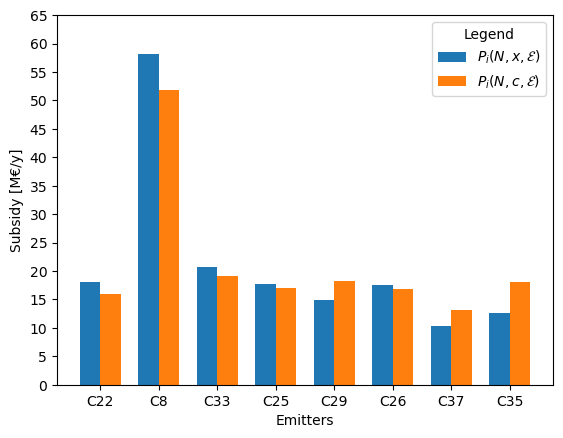

In [82]:
# Figure 6 in paper (revised verson V2)
# Specify colors for P_x and P_c using RGB tuples
p_colors = [(31, 119, 180), (255, 127, 14)]  # Example RGB tuples

# Normalize RGB values to be between 0 and 1
p_colors = [(r / 255, g / 255, b / 255) for r, g, b in p_colors]

# Plotting
fig, ax = plt.subplots()

bar_width = 0.35
index = np.arange(len(res_P.columns))

bar1 = ax.bar(index, res_P.loc['P_x'], bar_width, label='$P_{i}(N,x,\mathcal{E})$', color=p_colors[0])
bar2 = ax.bar(index + bar_width, res_P.loc['P_c'], bar_width, label='$P_{i}(N,c,\mathcal{E})$', color=p_colors[1])

ax.set_xlabel('Emitters')
ax.set_ylabel('Subsidy [M€/y]')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(res_P.columns)

# Adding y ticks at intervals of 5
ax.set_yticks(np.arange(0, max(res_P.values.max(), 5) + 5, 5))

ax.legend(title='Legend')

# plt.savefig('P_plot_v2.pgf',bbox_inches = "tight")
plt.savefig(NOTEBOOK_PATH/'results'/'figures'/'Figure_6.png', bbox_inches="tight")


plt.show()


## Figure 7

In [77]:
# Definition of regret (see paper)
regret_x = (res_P.loc['ci'] - res_P.loc['P_x']) / res_P.loc['ci']
regret_c = (res_P.loc['ci'] - res_P.loc['P_c']) / res_P.loc['ci']

# Add the new row to the dataframe
res_P.loc['regret_x'] = regret_x
res_P.loc['regret_c'] = regret_c

In [78]:
res_P.round(2)

start_pt,C22,C8,C33,C25,C29,C26,C37,C35
P_c,15.88,51.76,19.05,16.98,18.29,16.92,13.07,18.05
P_x,18.10,58.22,20.68,17.73,14.84,17.48,10.33,12.62
xi,18.83,60.56,21.51,18.44,15.44,18.18,10.75,13.13
ci,18.96,61.78,22.74,20.27,21.83,20.19,15.60,21.54
regret_x,0.05,0.06,0.09,0.13,0.32,0.13,0.34,0.41
regret_c,0.16,0.16,0.16,0.16,0.16,0.16,0.16,0.16


In [79]:
# Specify colors for P_x and P_c using RGB tuples
p_colors = [(31, 119, 180), (255, 127, 14), (0, 0, 0)]  # Example RGB tuples

# Normalize RGB values to be between 0 and 1
p_colors = [(r / 255, g / 255, b / 255) for r, g, b in p_colors]


<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\%'
/var/folders/7m/np2d7tjn2qq0l6kgvwd4_y3c0000gn/T/ipykernel_14323/3955141519.py:8: SyntaxWarning: invalid escape sequence '\m'
  bar1 = ax.bar(index, res_P.loc['regret_x'], bar_width, label='$Regret_{i}(N,x,\mathcal{E})$ (normalized)', color=p_colors[0])
/var/folders/7m/np2d7tjn2qq0l6kgvwd4_y3c0000gn/T/ipykernel_14323/3955141519.py:9: SyntaxWarning: invalid escape sequence '\m'
  bar2 = ax.bar(index + bar_width, res_P.loc['regret_c'], bar_width, label='$Regret_{i}(N,c,\mathcal{E})$ (normalized)', color=p_colors[1])
/var/folders/7m/np2d7tjn2qq0l6kgvwd4_y3c0000gn/T/ipykernel_14323/3955141519.py:12: SyntaxWarning: invalid escape sequence '\%'
  ax.set_ylabel('Regret [\%]')


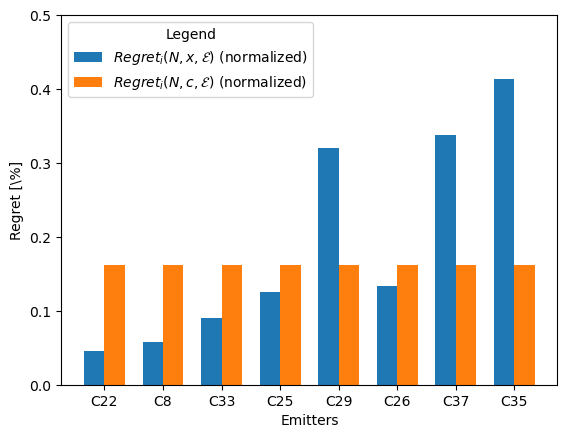

In [80]:
#  Regrets plot with comparison to c_i
# Plotting
fig, ax = plt.subplots()

bar_width = 0.35
index = np.arange(len(res_P.columns))

bar1 = ax.bar(index, res_P.loc['regret_x'], bar_width, label='$Regret_{i}(N,x,\mathcal{E})$ (normalized)', color=p_colors[0])
bar2 = ax.bar(index + bar_width, res_P.loc['regret_c'], bar_width, label='$Regret_{i}(N,c,\mathcal{E})$ (normalized)', color=p_colors[1])

ax.set_xlabel('Emitters')
ax.set_ylabel('Regret [\%]')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(res_P.columns)

# Adding y ticks at intervals of 5
# ax.set_yticks(np.arange(0, max(res_P.values.max(), 5) + 5, 5))
ax.set_yticks(np.arange(0, 0.6, 0.1))

ax.legend(title='Legend')

# plt.savefig('P_plot_regret_v2.pgf',bbox_inches = "tight")
plt.savefig(NOTEBOOK_PATH/'results'/'figures'/'Figure_7.png', bbox_inches="tight")

plt.show()


## CEA figure

Note that this figure is not in the paper

In [81]:
# # Specify colors for CEA_x and CEA_c
# cea_colors = [(31, 119, 180), (255, 127, 14)] 

# # Normalize RGB values to be between 0 and 1
# cea_colors = [(r / 255, g / 255, b / 255) for r, g, b in cea_colors]

# # Plotting
# fig, ax = plt.subplots()

# bar_width = 0.35
# index = np.arange(len(res_cea.columns))

# bar1 = ax.bar(index, res_cea.loc['CEA_x'], bar_width, label='$CEA_{i}(N,x,\mathcal{E})$', color=cea_colors[0])
# bar2 = ax.bar(index + bar_width, res_cea.loc['CEA_c'], bar_width, label='$CEA_{i}(N,c,\mathcal{E})$', color=cea_colors[1])

# ax.set_xlabel('Emitters')
# ax.set_ylabel('Subsidy')
# ax.set_xticks(index + bar_width / 2)
# ax.set_xticklabels(res_cea.columns)

# # Adding y ticks at intervals of 5
# ax.set_yticks(np.arange(0, max(res_cea.values.max(), 5) + 5, 5))

# ax.legend(title='Legend')

# # plt.savefig('CEA_plot_v2.pgf',bbox_inches = "tight")

# plt.show()
